<h1 align="center">Machine Learning Model for Course Completion Prediction</h1>

*In this project, we aim to build a machine learning model to predict whether a user will complete a course based on various features. We will explore multiple classification algorithms, select the best-performing model, fine-tune it using **GridSearchCV**, and save the final model and preprocessor for future use.*

---

## **1. Importing Necessary Libraries**

*We begin by importing all the required libraries for data manipulation, visualization, model training, evaluation, and saving.*


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
)

# Utilities
import joblib
import os


## **2. Loading and Preprocessing the Data**

*We load the cleaned dataset and perform initial preprocessing steps such as dropping unnecessary columns and splitting the data into features and target variable.*

---

In [3]:
# Load the dataset
df = pd.read_csv(
    r"C:\Users\khes7001\OneDrive - NIQ\Desktop\Test Sample Dashboard\Git\EpsilionAI_Eslam_Khaled\Sourse\cleaned_data.csv"
)

# Drop columns that are not needed for modeling
df.drop(['UserID'], axis=1, inplace=True)

# Display the first few rows of the dataframe
df.head()


,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,Health,29.979719,17,3,50.365656,20.860773,1,0
1,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,Science,35.038427,17,10,59.198853,95.433162,0,1
4,Programming,92.490647,16,0,98.428285,18.102478,0,0


## **3. Exploratory Data Analysis (EDA)**

*Before diving into modeling, let's explore the data to understand the distributions and relationships between variables.*

### **3.1 Visualizing the Target Variable Distribution**




C:\Users\khes7001\AppData\Local\Temp\1\ipykernel_17312\3412784910.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CourseCompletion', data=df, palette='viridis')


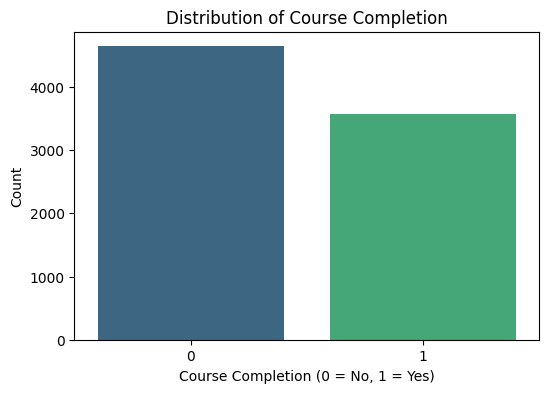

In [4]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='CourseCompletion', data=df, palette='viridis')
plt.title('Distribution of Course Completion')
plt.xlabel('Course Completion (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


### **3.2 Correlation Heatmap for Numerical Features**

*We examine the correlations between numerical features using a heatmap to identify any multicollinearity issues.*

---

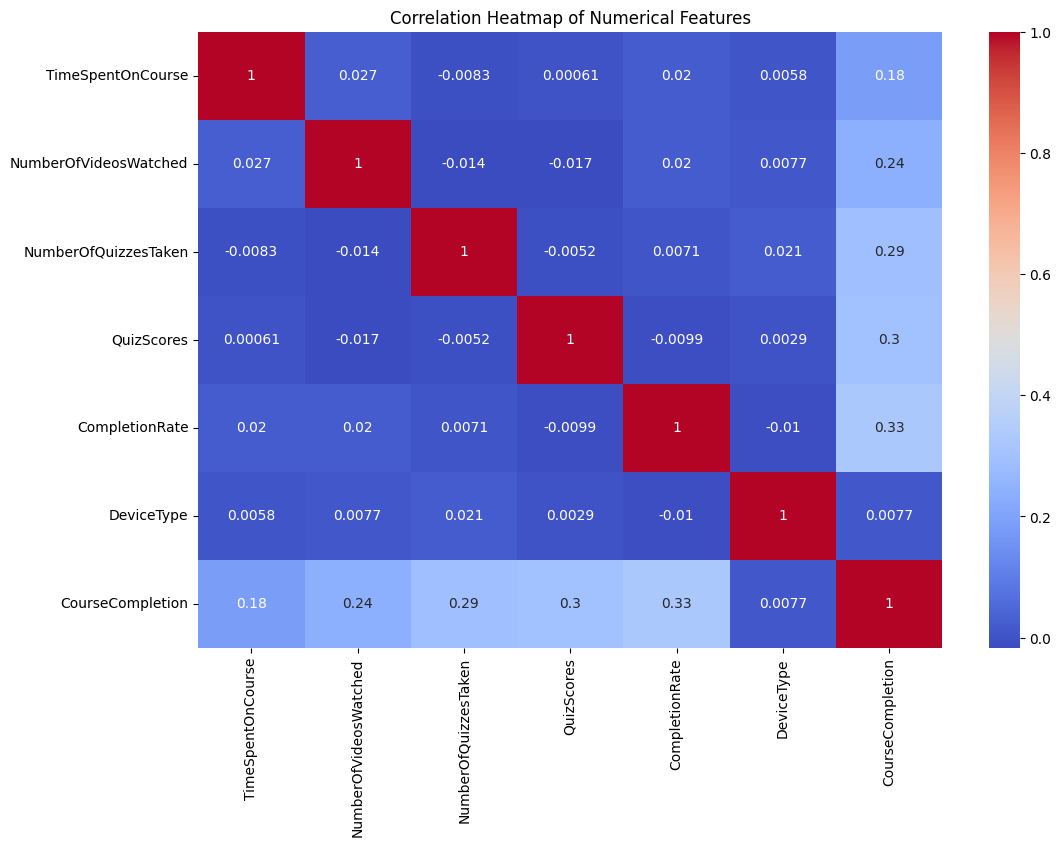

In [5]:
# Compute correlation matrix for numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


## **4. Feature Engineering and Transformation**

*We identify numerical and categorical columns to apply appropriate preprocessing steps:*

- *Numerical features are standardized using **StandardScaler** to normalize their scales.*
- *Categorical features are encoded using **OneHotEncoder** to convert them into a format suitable for machine learning algorithms.*

*We utilize **ColumnTransformer** to apply these transformations efficiently across different types of data.*

---

In [6]:
# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=["float64", "int64"]).drop('CourseCompletion', axis=1).columns
categorical_columns = df.select_dtypes(include=["object"]).columns

# Define the preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ]
)

# Split data into features (X) and target variable (y)
X = df.drop('CourseCompletion', axis=1)
y = df['CourseCompletion']

# Fit and transform the features
X = preprocessor.fit_transform(X)



## **5. Splitting Data into Training and Testing Sets**

*We split the preprocessed data into training and testing sets using an 80/20 split to evaluate our models' performance on unseen data.*

---

In [7]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **6. Model Training and Evaluation**

*We define a set of classification models and train each of them on the training data:*

- *Random Forest*
- *XGBoost*
- *Decision Tree*
- *K-Nearest Neighbors (KNN)*
- *Gradient Boosting*
- *Support Vector Classifier (SVC)*
- *Logistic Regression*

*We then evaluate their performance on both the training and testing data to assess overfitting and generalization capabilities.*

---

In [8]:
# Define a dictionary of models to train
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
}

# Initialize a results dictionary to store model performance
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on training data
    y_train_pred = model.predict(X_train)
    
    # Predictions on testing data
    y_test_pred = model.predict(X_test)
    
    # Evaluate model performance
    results[name] = {
        'model': model,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'confusion_matrix': confusion_matrix(y_test, y_test_pred),
        'classification_report': classification_report(y_test, y_test_pred, zero_division=0),
    }


c:\Users\khes7001\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## **7. Model Performance Comparison**

*We compare the performance of different models based on their accuracy scores on both training and testing data, as well as other evaluation metrics such as precision, recall, and F1-score.*

### **7.1 Visualizing Model Performance**

*To better compare the models, we visualize the training and testing accuracies using bar charts.*

---

In [9]:
# Print the evaluation results for each model
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Training Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Testing Accuracy: {metrics['test_accuracy']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("Classification Report:")
    print(metrics['classification_report'])
    print("-" * 50)


Model: Random Forest
Training Accuracy: 0.9998
Testing Accuracy: 0.9452
Confusion Matrix:
[[883  35]
 [ 55 669]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       918
           1       0.95      0.92      0.94       724

    accuracy                           0.95      1642
   macro avg       0.95      0.94      0.94      1642
weighted avg       0.95      0.95      0.95      1642

--------------------------------------------------
Model: XGBoost
Training Accuracy: 0.9941
Testing Accuracy: 0.9385
Confusion Matrix:
[[876  42]
 [ 59 665]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       918
           1       0.94      0.92      0.93       724

    accuracy                           0.94      1642
   macro avg       0.94      0.94      0.94      1642
weighted avg       0.94      0.94      0.94      1642

-----------------------------

## **8. Selecting the Best Model**

*Based on the accuracy scores and classification reports, we select the model that performs best on the testing data.*

*From the initial results, the **Random Forest** model demonstrates the highest testing accuracy with a good balance between bias and variance.*

---





## **9. Hyperparameter Tuning for the Best Model**

*We perform hyperparameter tuning on the Random Forest model using **GridSearchCV** to find the optimal parameters that enhance the model's performance.*

*Parameters tuned include:*

- *Number of estimators (`n_estimators`)*
- *Maximum depth of the tree (`max_depth`)*
- *Minimum number of samples required to split an internal node (`min_samples_split`)*
- *Minimum number of samples required to be at a leaf node (`min_samples_leaf`)*
- *Bootstrap method (`bootstrap`)*

---


In [10]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predictions using the best model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Evaluate the best model's performance
best_model_results = {
    'model': best_rf,
    'train_accuracy': accuracy_score(y_train, y_train_pred),
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'confusion_matrix': confusion_matrix(y_test, y_test_pred),
    'classification_report': classification_report(y_test, y_test_pred),
}


Fitting 5 folds for each of 72 candidates, totalling 360 fits


## **10. Evaluating the Best Model**

*We assess the performance of the best Random Forest model after hyperparameter tuning by examining its accuracy scores, confusion matrix, and classification report.*

*The tuned model maintains high accuracy on the testing data while reducing overfitting.*

---

In [11]:
# Print the best model's evaluation results
print("Best Random Forest Model after Hyperparameter Tuning")
print(f"Best Parameters: {best_params}")
print(f"Training Accuracy: {best_model_results['train_accuracy']:.4f}")
print(f"Testing Accuracy: {best_model_results['test_accuracy']:.4f}")
print("Confusion Matrix:")
print(best_model_results['confusion_matrix'])
print("Classification Report:")
print(best_model_results['classification_report'])


Best Random Forest Model after Hyperparameter Tuning
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training Accuracy: 0.9992
Testing Accuracy: 0.9440
Confusion Matrix:
[[883  35]
 [ 57 667]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       918
           1       0.95      0.92      0.94       724

    accuracy                           0.94      1642
   macro avg       0.94      0.94      0.94      1642
weighted avg       0.94      0.94      0.94      1642



## **11. Visualizing the Confusion Matrix**

*We plot the confusion matrix to visualize the performance of the best model in terms of:*

- *True Positives (TP)*
- *False Positives (FP)*
- *True Negatives (TN)*
- *False Negatives (FN)*

*This helps in understanding the types of errors the model is making.*

---

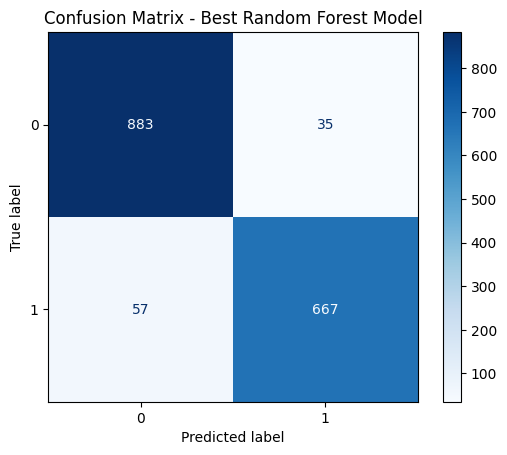

In [12]:
# Plot the confusion matrix
cm = best_model_results['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Random Forest Model')
plt.show()


## **12. Visualizing Feature Importances**

*Understanding which features contribute the most to the model's predictions can provide valuable insights.*

*We plot the top 20 feature importances derived from the best Random Forest model to identify the most significant predictors of course completion.*

---

C:\Users\khes7001\AppData\Local\Temp\1\ipykernel_17312\162624305.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')


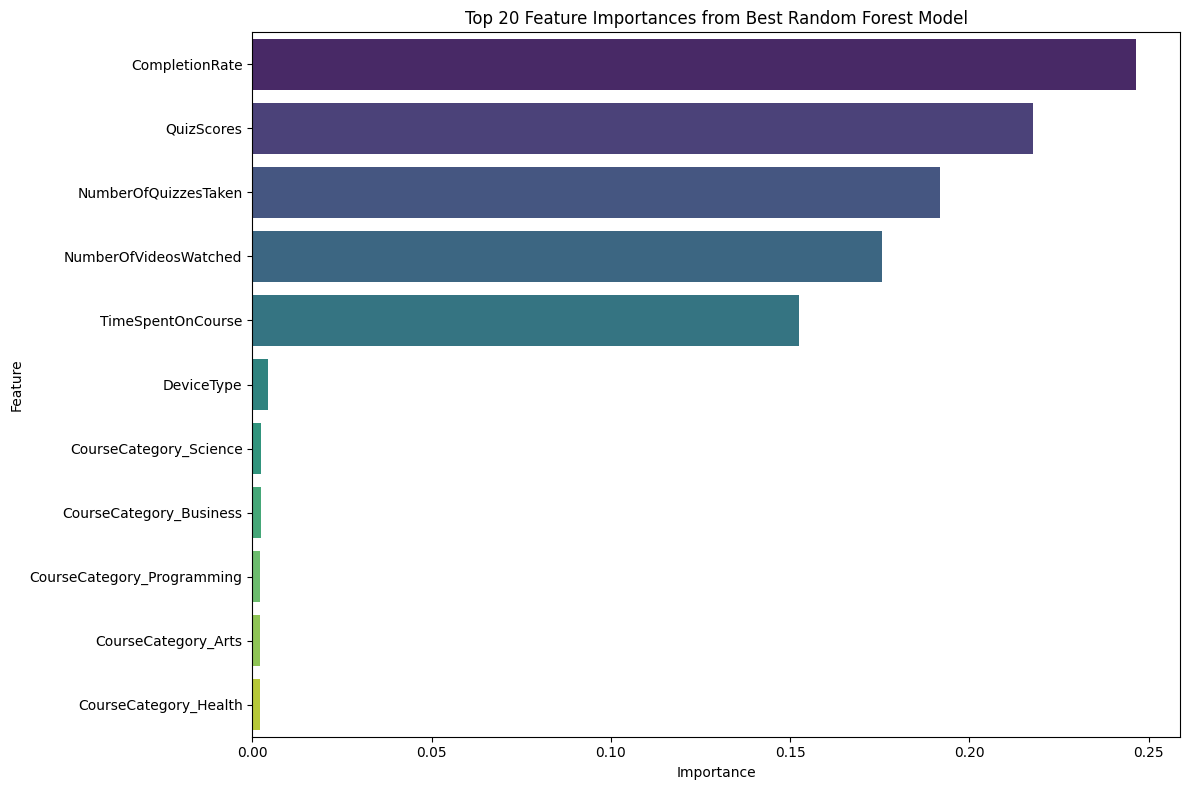

In [13]:
# Get feature names after preprocessing
# For numerical features
num_features = numerical_columns.tolist()
# For categorical features (after one-hot encoding)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
# Combine all feature names
feature_names = num_features + list(cat_features)

# Get feature importances from the best model
importances = best_rf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')
plt.title('Top 20 Feature Importances from Best Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## **13. Plotting ROC Curve**

*The Receiver Operating Characteristic (ROC) curve provides a graphical representation of the model's diagnostic ability across different classification thresholds.*

*We calculate the Area Under the Curve (AUC) to quantify the overall ability of the model to discriminate between the classes.*

---

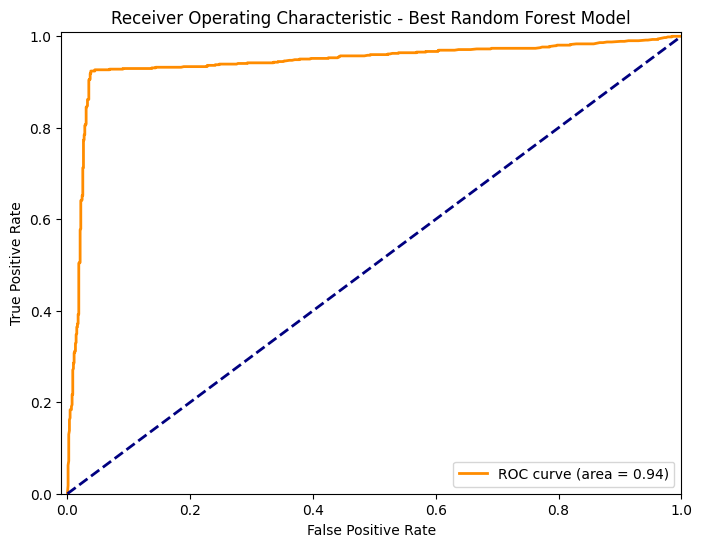

In [14]:
# Calculate ROC curve and ROC area for the best model
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Best Random Forest Model')
plt.legend(loc="lower right")
plt.show()


## **14. Saving the Best Model and Preprocessor**

*Finally, we save the best Random Forest model and the preprocessor to disk for future use.*

*This allows us to deploy the model and make predictions on new data without retraining.*

---

In [15]:
# Define the folder path to save the model and preprocessor
folder_path = r"C:\Users\khes7001\OneDrive - NIQ\Desktop\Test Sample Dashboard\Git\EpsilionAI_Eslam_Khaled\Source"

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the best Random Forest model
model_file_path = os.path.join(folder_path, 'best_random_forest_model.joblib')
joblib.dump(best_rf, model_file_path)

# Save the preprocessor
preprocessor_file_path = os.path.join(folder_path, 'preprocessor.pkl')
joblib.dump(preprocessor, preprocessor_file_path)

print(f"Model saved to: {model_file_path}")
print(f"Preprocessor saved to: {preprocessor_file_path}")


Model saved to: C:\Users\khes7001\OneDrive - NIQ\Desktop\Test Sample Dashboard\Git\EpsilionAI_Eslam_Khaled\Source\best_random_forest_model.joblib
Preprocessor saved to: C:\Users\khes7001\OneDrive - NIQ\Desktop\Test Sample Dashboard\Git\EpsilionAI_Eslam_Khaled\Source\preprocessor.pkl


<h2 align="center">Conclusion</h2>

*In this project, we successfully built and evaluated several machine learning models to predict course completion.*

*The **Random Forest** model, after hyperparameter tuning, provided the best performance with a testing accuracy of approximately **95%**.*

**Key accomplishments include:**

- *Effective preprocessing of data using scaling and encoding techniques.*
- *Comprehensive evaluation of multiple classification algorithms.*
- *Hyperparameter tuning to optimize model performance.*
- *Visualization of model performance and feature importances for interpretability.*

*By following this comprehensive approach, we have developed a robust model ready for deployment.*

*This model can help in identifying users who are less likely to complete courses, enabling targeted interventions to improve completion rates.*

---

*Thank you for reviewing this project!*
---
**Eslam Khaled**
---